In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
# import MeshCat as mc 
# using JLD2
using Test
# using Random
# include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))
# include(joinpath(@__DIR__,"utils/basin_of_attraction.jl"))

  Activating environment at `~/nCBF-drone/danaus_ros_ws/julia_eth/Project.toml`
   Installed Xorg_libXfixes_jll ─────────── v5.0.3+4
   Installed Ogg_jll ────────────────────── v1.3.5+1
   Installed XSLT_jll ───────────────────── v1.1.34+0
   Installed Expat_jll ──────────────────── v2.6.2+0
   Installed Xorg_libSM_jll ─────────────── v1.2.4+0
   Installed libvorbis_jll ──────────────── v1.3.7+1
   Installed TensorCore ─────────────────── v0.1.1
   Installed StatsBase ──────────────────── v0.34.3
   Installed Xorg_libXext_jll ───────────── v1.3.6+0
   Installed ConcurrentUtilities ────────── v2.4.1
   Installed DataStructures ─────────────── v0.18.20
   Installed HTTP ───────────────────────── v1.10.8
   Installed Gettext_jll ────────────────── v0.21.0+0
   Installed ChangesOfVariables ─────────── v0.1.8
   Installed Format ─────────────────────── v1.3.7
   Installed Xorg_xcb_util_image_jll ────── v0.4.0+1
   Installed libinput_jll ───────────────── v1.18.0+0
   Installed DataAPI ─────

## TODO

### 1. Verify that Simin's dynamics works, in particular the pendulum dynamics
In order to this, we need to use the ETH dynamics, in particular ETH's pendulum dynamics. We know for a fact that the ETH dynamics works in real life since we successfully deployed.
- Simulation Dynamics: ETH
- Observer: Convert $r$ and $s$ into roll and pitch of pendulum, and use the time-differentiation for the velocities.
- Controller Dynamics: Simin's

- Control inputs: $a, \omega_x, \omega_y, \omega_z$
    - [P0] Ensure that Simin's dynamics has the same coordinate system for both the dynamics and controls!

Repeat 1~3 for $dt = 0.01$:
1. State <-- ETH Dynamics
2. New State <-- Observer
    - Check how much error there is between these two!
3. Control Input <-- Simin's Dynamics

### 2. See if torque-to-body-rate conversion may work in low-fidelity simulation at 100 Hz
We want to see the naive torque-to-body-rate (TTBR) can stabilize the pendulum at 100 Hz. For this, we do the following:
- Simulation Dynamics: ETH for torque
- Observer: Time-differentiation for $r$ and $s$ OR roll and pitch of pendulum.
- Controller Dynamics: 
    1. Simin's if Task #1 proves that her dynamics is good.
    2. ETH's dynamics with torque control if not.

In [2]:
function rk4(dyn::Function, params::NamedTuple, x::Vector, u::Vector, dt::Float64)
    k1 = dt*dyn(params, x, u)
    k2 = dt*dyn(params, x + 0.5*k1, u)
    k3 = dt*dyn(params, x + 0.5*k2, u)
    k4 = dt*dyn(params, x + k3, u)
    
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

In [3]:
function eth_bodyrate_dynamics(params::NamedTuple, X::Vector, u::Vector)
    """
    The dynamics of the ETH quadrotor-pendulum model.
    This dynamics has 13 states and 4 inputs.
    The inputs are body-rates and overall thrust.
    The thrust is NOT normalized about the hovering position.
    """
    
    g = params.g
    L = params.L

    γ, β, α, x, y, z, x_dot, y_dot, z_dot, r, s, r_dot, s_dot = X
    a, wx, wy, wz = u
    
    Rx = [1 0 0; 0 cos(γ) -sin(γ); 0 sin(γ) cos(γ)]
    Ry = [cos(β) 0 sin(β); 0 1 0; -sin(β) 0 cos(β)]
    Rz = [cos(α) -sin(α) 0; sin(α) cos(α) 0; 0 0 1]
    R = Rz*Ry*Rx

    pos_ddot = R * [0; 0; a] + [0; 0; -g]
    x_ddot, y_ddot, z_ddot = pos_ddot
    
    rot_dot = [cos(β)*cos(γ) -sin(γ) 0; cos(β)*sin(γ) cos(γ) 0; -sin(β) 0 1]\[wx; wy; wz]
    γ_dot, β_dot, α_dot = rot_dot

    ξ = sqrt(L^2 - r^2 - s^2)

    r_ddot = (L^4*x_ddot - r^3*s_dot^2 + r^4*x_ddot + r*s^3*y_ddot + r^3*s*y_ddot + L^2*r*r_dot^2 + L^2*r*s_dot^2 - 2*L^2*r^2*x_ddot - L^2*s^2*x_ddot + g*r^3*(L^2 - r^2 - s^2)^(1/2) - r*r_dot^2*s^2 + r^3*z_ddot*(L^2 - r^2 - s^2)^(1/2) + r^2*s^2*x_ddot - L^2*r*s*y_ddot + 2*r^2*r_dot*s*s_dot - L^2*g*r*(L^2 - r^2 - s^2)^(1/2) - L^2*r*z_ddot*(L^2 - r^2 - s^2)^(1/2) + g*r*s^2*(L^2 - r^2 - s^2)^(1/2) + r*s^2*z_ddot*(L^2 - r^2 - s^2)^(1/2))/(L^2*(- L^2 + r^2 + s^2))
    s_ddot = (L^4*y_ddot - r_dot^2*s^3 + s^4*y_ddot + r*s^3*x_ddot + r^3*s*x_ddot + L^2*r_dot^2*s + L^2*s*s_dot^2 - L^2*r^2*y_ddot - 2*L^2*s^2*y_ddot + g*s^3*(L^2 - r^2 - s^2)^(1/2) - r^2*s*s_dot^2 + s^3*z_ddot*(L^2 - r^2 - s^2)^(1/2) + r^2*s^2*y_ddot - L^2*r*s*x_ddot + 2*r*r_dot*s^2*s_dot - L^2*g*s*(L^2 - r^2 - s^2)^(1/2) - L^2*s*z_ddot*(L^2 - r^2 - s^2)^(1/2) + g*r^2*s*(L^2 - r^2 - s^2)^(1/2) + r^2*s*z_ddot*(L^2 - r^2 - s^2)^(1/2))/(- L^4 + L^2*r^2 + L^2*s^2)

    return [γ_dot; β_dot; α_dot; x_dot; y_dot; z_dot; x_ddot; y_ddot; z_ddot; r_dot; s_dot; r_ddot; s_ddot]
end

eth_bodyrate_dynamics (generic function with 1 method)

In [4]:
function our_dynamics(params::NamedTuple, X::Vector, u::Vector)
    """
    The dynamics of our quadrotor-pendulum model.
    This dynamics has 13 states and 4 inputs.
    The inputs are also bodyrate and overall thrust.
    The thrust is NOT normalized about the hovering position.
    """
    
    g = params.g
    L = params.L
    if L < 1.0
        display("We assume that the CoM of pendulum is at the center of pendulum.")
    end
    
    display("The CoM of the pendulum is at $L m.")

    γ, β, α, x, y, z, x_dot, y_dot, z_dot, θ, ϕ, θ_dot, ϕ_dot = X
    a, wx, wy, wz = u
    
    Rx = [1 0 0; 0 cos(γ) -sin(γ); 0 sin(γ) cos(γ)]
    Ry = [cos(β) 0 sin(β); 0 1 0; -sin(β) 0 cos(β)]
    Rz = [cos(α) -sin(α) 0; sin(α) cos(α) 0; 0 0 1]
    R = Rz*Ry*Rx

    pos_ddot = R * [0; 0; a] + [0; 0; -g]
    x_ddot, y_ddot, z_ddot = pos_ddot
    
    # Note that the angular velocity dynamics is from ETH, not our paper.
    rot_dot = [cos(β)*cos(γ) -sin(γ) 0; cos(β)*sin(γ) cos(γ) 0; -sin(β) 0 1]\[wx; wy; wz]
    γ_dot, β_dot, α_dot = rot_dot

    # r = L*tan(θ)
    # s = L*tan(ϕ)    # sign does not matter (?)
    # ξ = sqrt(L^2 - r^2 - s^2)

    θ_ddot = 3/(2*(2*L)) * (-x_ddot*cos(θ) - y_ddot*sin(ϕ)*sin(θ) + (z_ddot+g)*cos(ϕ)*sin(θ)) - ϕ_dot^2*sin(θ)*cos(θ)
    ϕ_ddot = 3/(2*(2*L)*cos(θ)) * (y_ddot*cos(ϕ) + (z_ddot+g)*sin(ϕ)) + 2*θ_dot*ϕ_dot*tan(θ)

    return [γ_dot; β_dot; α_dot; x_dot; y_dot; z_dot; x_ddot; y_ddot; z_ddot; θ_dot; ϕ_dot; θ_ddot; ϕ_ddot]
end

our_dynamics (generic function with 1 method)

In [25]:
function observer(params::NamedTuple, X::Vector)
    g = params.g
    L = params.L

    # Unpack the states, according to ETH model
    γ, β, α, x, y, z, x_dot, y_dot, z_dot, r, s, r_dot, s_dot = X

    ζ = sqrt(L^2 - r^2 - s^2)
    θ = atan(r, ζ)
    ϕ = atan(-s, ζ)
    θ_dot = r_dot/L
    ϕ_dot = -s_dot/L

    return [γ; β; α; x; y; z; x_dot; y_dot; z_dot; θ; ϕ; θ_dot; ϕ_dot]

end

observer (generic function with 1 method)

In [6]:
#############################################
#################### LQR ####################
#############################################

# Define the parameters
nx = 13
nu = 4

dt = 1/100  # 100 Hz

g = 9.81
L = 0.5 # CoM of pendulum from its base
params = (g = g, L = L)

# Define the goals
xgoal = [0; 0; 0; 0; 0; 3; 0; 0; 0; 0; 0; 0; 0]
ugoal = [g; 0; 0; 0]

A_eth = FD.jacobian(x -> rk4(eth_bodyrate_dynamics, params, x, ugoal, dt), xgoal)
B_eth = FD.jacobian(u -> rk4(eth_bodyrate_dynamics, params, xgoal, u, dt), ugoal)

A_ours = FD.jacobian(x -> rk4(our_dynamics, params, x, ugoal, dt), xgoal)
B_ours = FD.jacobian(u -> rk4(our_dynamics, params, xgoal, u, dt), ugoal)

Q = 1.0*diagm([0; 0; 0; 1; 1; 1; 0; 0; 0; 0.5; 0.5; 0; 0])
R = 1.0*diagm([10; 1; 1; 1])

sing = 1e-6

################ OURS ################
P = deepcopy(Q)
K_old = (R + B_ours'*P*B_ours)\B_ours'*P*A_ours
P_old = Q + A_ours'*P*(A_ours - B_ours*K_old)

K_ours = deepcopy(K_old)

for i = 1:10000
    K_new = (R + B_ours'*P_old*B_ours)\B_ours'*P_old*A_ours
    P_new = Q + A_ours'*P_old*(A_ours - B_ours*K_new)
    if norm(K_new - K_old) < 1e-5
        println("Converged at iteration $i")
        K_ours = K_new
        break
    end
    K_old = K_new
    P_old = P_new
end

################ ETH ################
P = deepcopy(Q)
K_old = (R + B_eth'*P*B_eth)\B_eth'*P*A_eth
P_old = Q + A_eth'*P*(A_eth - B_eth*K_old)

K_eth = deepcopy(K_old)

for i = 1:10000
    K_new = (R + B_eth'*P*B_eth)\B_eth'*P_old*A_eth
    P_new = Q + A_eth'*P_old*(A_eth - B_eth*K_new)
    if norm(K_new - K_old) < 1e-5
        println("Converged at iteration $i")
        K_eth = K_new
        break
    end
    K_old = K_new
    P_old = P_new
end

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

"We assume that the CoM of pendulum is at the center of pendulum."

"The CoM of the pendulum is at 0.5 m."

Converged at iteration 1064
Converged at iteration 1062


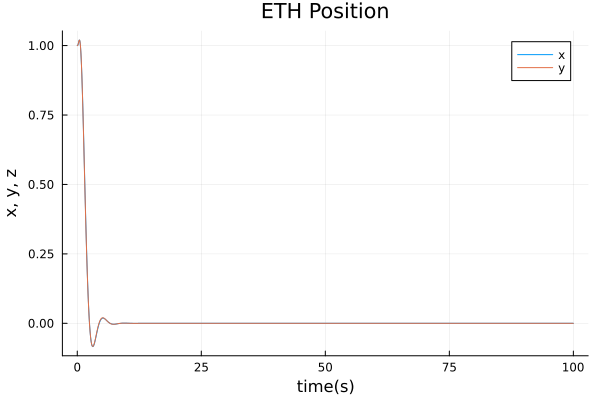

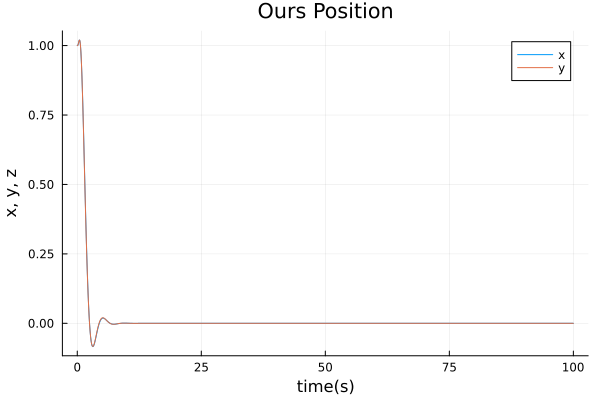

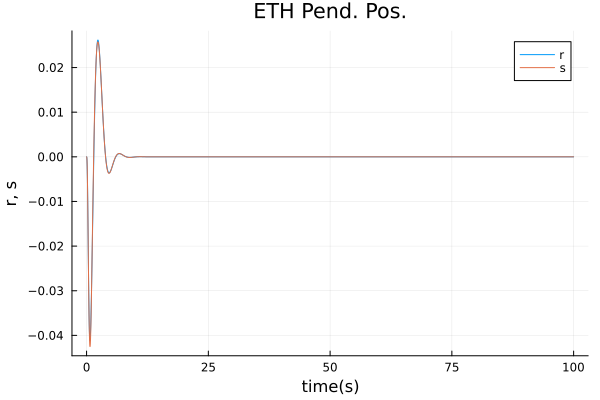

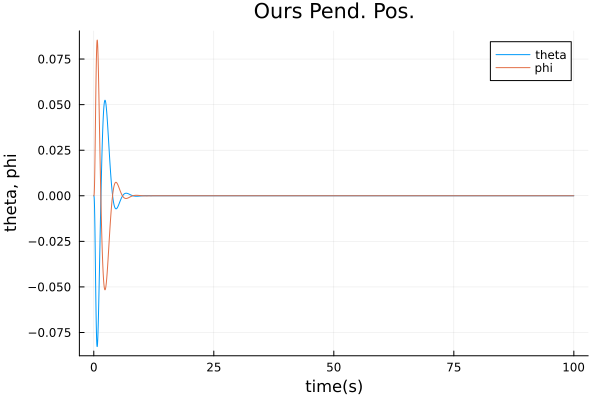

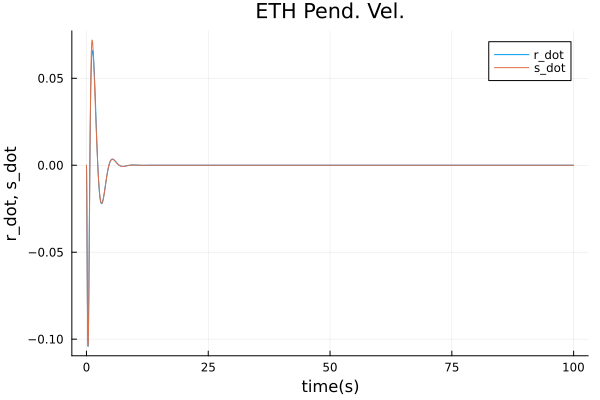

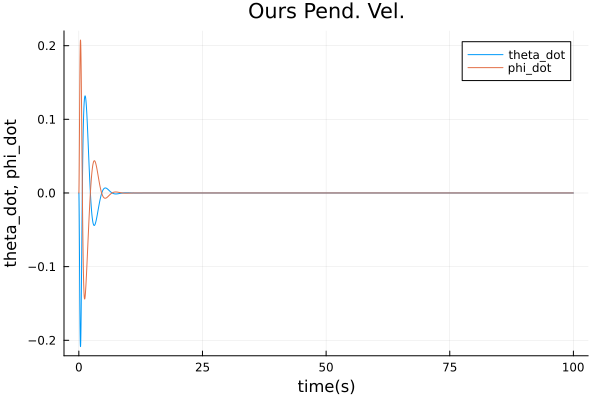

In [26]:
#############################################
#################### SIM ####################
#############################################

x0 = [0; 0; 0; 1; 1; 3; 0; 0; 0; 0; 0; 0; 0]

tf = 100.0
t_vec = 0:dt:tf
N = length(t_vec)
X_eth = [zeros(nx) for i = 1:N] # ETH
X_ours = [zeros(nx) for i = 1:N] # Ours
U_ours = [zeros(nu) for i = 1:N-1] # Ours
X_eth[1] = x0
X_ours[1] = observer(params, X_eth[1])

for k = 1:N-1
    _X_ours = observer(params, X_eth[k])
    _U = ugoal - K_ours*(_X_ours - xgoal)
    _X_eth = rk4(eth_bodyrate_dynamics, params, X_eth[k], _U, dt)
    X_eth[k+1] = _X_eth
    X_ours[k+1] = _X_ours
    U_ours[k] = _U
end

Xm_eth = hcat(X_eth...)
Xm_ours = hcat(X_ours...)
Um_ours = hcat(U_ours...)

display(plot(t_vec[1:N-1],(Xm_eth[4:5,1:N-1])',title = "ETH Position",
            xlabel = "time(s)", ylabel = "x, y, z",
            label = ["x" "y" "z"]))
display(plot(t_vec[1:N-1],(Xm_ours[4:5,1:N-1])',title = "Ours Position",
            xlabel = "time(s)", ylabel = "x, y, z",
            label = ["x" "y" "z"]))
display(plot(t_vec[1:N-1],(Xm_eth[10:11,1:N-1])',title = "ETH Pend. Pos.",
            xlabel = "time(s)", ylabel = "r, s",
            label = ["r" "s"]))
display(plot(t_vec[1:N-1],(Xm_ours[10:11,1:N-1])',title = "Ours Pend. Pos.",
            xlabel = "time(s)", ylabel = "theta, phi",
            label = ["theta" "phi"]))      
display(plot(t_vec[1:N-1],(Xm_eth[12:13,1:N-1])',title = "ETH Pend. Vel.",
            xlabel = "time(s)", ylabel = "r_dot, s_dot",
            label = ["r_dot" "s_dot"]))
display(plot(t_vec[1:N-1],(Xm_ours[12:13,1:N-1])',title = "Ours Pend. Vel.",
            xlabel = "time(s)", ylabel = "theta_dot, phi_dot",
            label = ["theta_dot" "phi_dot"]))          

# Xm = hcat(X...)
# Um = hcat([ugoal - K_ours*(X[k] - xgoal) for k = 1:N]...)
# display(plot(t_vec[1:N-1],(Xm[4:5,1:N-1])',title = "Position",
#             xlabel = "time(s)", ylabel = "x, y, z",
#             label = ["x" "y" "z"]))

# display(plot(t_vec[1:N-1],(Xm[10:11,1:N-1])',title = "Pend. Pos.",
#             xlabel = "time(s)", ylabel = "theta, phi",
#             label = ["theta" "phi"]))        
# display(plot(t_vec[1:N-1],(Xm[12:13,1:N-1])',title = "Pend. Vel.",
#             xlabel = "time(s)", ylabel = "theta_dot, phi_dot",
#             label = ["theta_dot" "phi_dot"]))

In [9]:
using Printf

In [19]:
function print_np_matrix(mat)
    rows, cols = size(mat)
    for i in 1:rows
        print("[")
        for j in 1:cols
            @printf("%10.6g, ", mat[i, j])
        end
        print("]")
        println()
    end
end
function print_latex_matrix(mat)
    rows, cols = size(mat)
    for i in 1:rows
        for j in 1:cols
            @printf("%10.5g ", mat[i, j])
            print("&")
        end
        println()
    end
end

print_latex_matrix (generic function with 1 method)

In [22]:
print_np_matrix(A_ours)
print_np_matrix(B_ours)

[         1,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0, ]
[         0,          1,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0, ]
[         0,          0,          1,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0, ]
[         0,  0.0004905,          0,          1,          0,          0,       0.01,          0,          0,          0,          0,          0,          0, ]
[-0.0004905,          0,          0,          0,          1,          0,          0,       0.01,          0,          0,          0,          0,          0, ]
[         0,          0,          0,          0,          0,          1,          0,          0,       0.01,          0,          0,          0,          0, ]
[         0,     0.0981,          0,          

In [21]:
print_np_matrix(A_eth)
print_np_matrix(B_eth)

[         1,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0, ]
[         0,          1,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0, ]
[         0,          0,          1,          0,          0,          0,          0,          0,          0,          0,          0,          0,          0, ]
[         0,  0.0004905,          0,          1,          0,          0,       0.01,          0,          0,          0,          0,          0,          0, ]
[-0.0004905,          0,          0,          0,          1,          0,          0,       0.01,          0,          0,          0,          0,          0, ]
[         0,          0,          0,          0,          0,          1,          0,          0,       0.01,          0,          0,          0,          0, ]
[         0,     0.0981,          0,          